In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pytorch_tabular import TabularModel
from pytorch_tabular.config import DataConfig, TrainerConfig, OptimizerConfig
from pytorch_tabular.models.tab_transformer.config import TabTransformerConfig
from sklearn.metrics import classification_report, confusion_matrix


In [59]:
import pandas as pd

file_path = '/content/drive/MyDrive/Microbiota Status Classification/health_data_10000_chunk.csv'
df = pd.read_csv(file_path)


df_info = df.info()
df_head = df.head()
df_description = df.describe(include='all')

df_info, df_head, df_description

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 54 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Height (cm)                                       10000 non-null  int64  
 1   Weight (kg)                                       10000 non-null  int64  
 2   BMI                                               10000 non-null  float64
 3   Medical conditions                                10000 non-null  object 
 4   Medications in use                                10000 non-null  object 
 5   Residential Address                               10000 non-null  object 
 6   Previous gastrointestinal issues                  10000 non-null  bool   
 7   Family history of diseases                        10000 non-null  object 
 8   Previous surgeries                                10000 non-null  object 
 9   Previous therapies

(None,
    Height (cm)  Weight (kg)   BMI    Medical conditions  \
 0          173          120  40.1      Diabetes, Anemia   
 1          183          110  32.8        Asthma, Anemia   
 2          160          111  43.4  Hypertension, Asthma   
 3          177           75  23.9        Anemia, Asthma   
 4          170           97  33.6  Hypertension, Asthma   
 
        Medications in use                                Residential Address  \
 0  Aspirin, Levothyroxine  17761 Coleman Coves Suite 307\nWest Ryan, FL 8...   
 1     Lisinopril, Aspirin       11610 Thompson Trail\nSouth Steven, CA 97229   
 2     Aspirin, Lisinopril      89841 Nguyen Station\nNew Jennafurt, WA 05070   
 3   Metformin, Lisinopril               194 Adam Alley\nRoachville, CO 73756   
 4     Lisinopril, Insulin  420 Griffin Rest Suite 963\nNew Allisonburgh, ...   
 
    Previous gastrointestinal issues   Family history of diseases  \
 0                              True             Cancer, Diabetes   
 1   

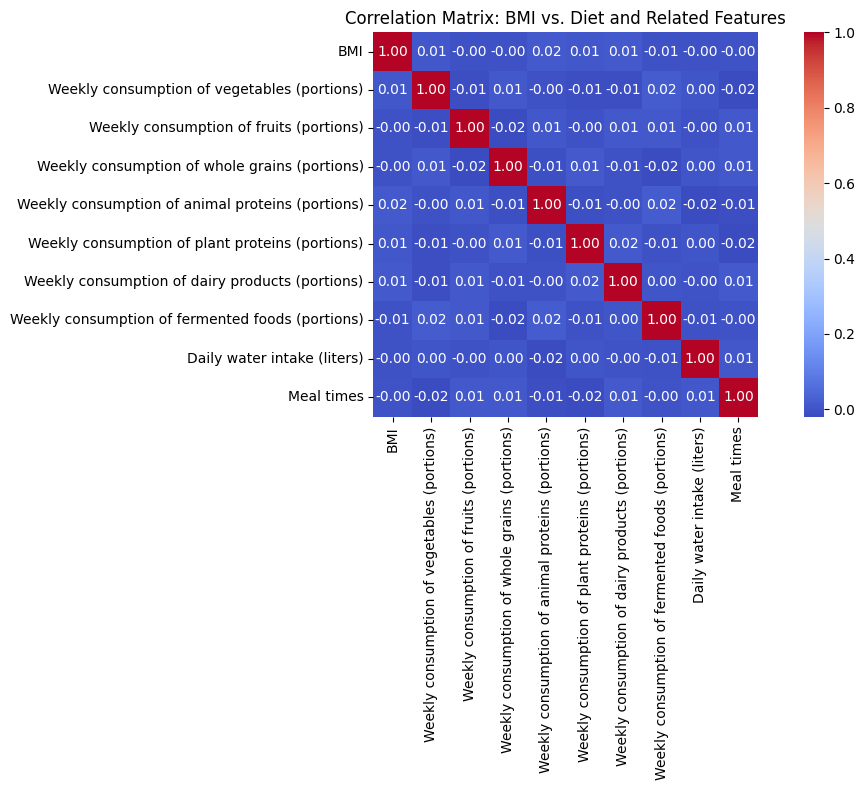

In [60]:
# Select numerical dietary and BMI-related features
diet_bmi_features = [
    'BMI',
    'Weekly consumption of vegetables (portions)',
    'Weekly consumption of fruits (portions)',
    'Weekly consumption of whole grains (portions)',
    'Weekly consumption of animal proteins (portions)',
    'Weekly consumption of plant proteins (portions)',
    'Weekly consumption of dairy products (portions)',
    'Weekly consumption of fermented foods (portions)',
    'Daily water intake (liters)',
    'Meal times'
]

# Calculate the correlation matrix
correlation_matrix = df[diet_bmi_features].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix: BMI vs. Diet and Related Features")
plt.tight_layout()
plt.show()


Detect outliers and missing values


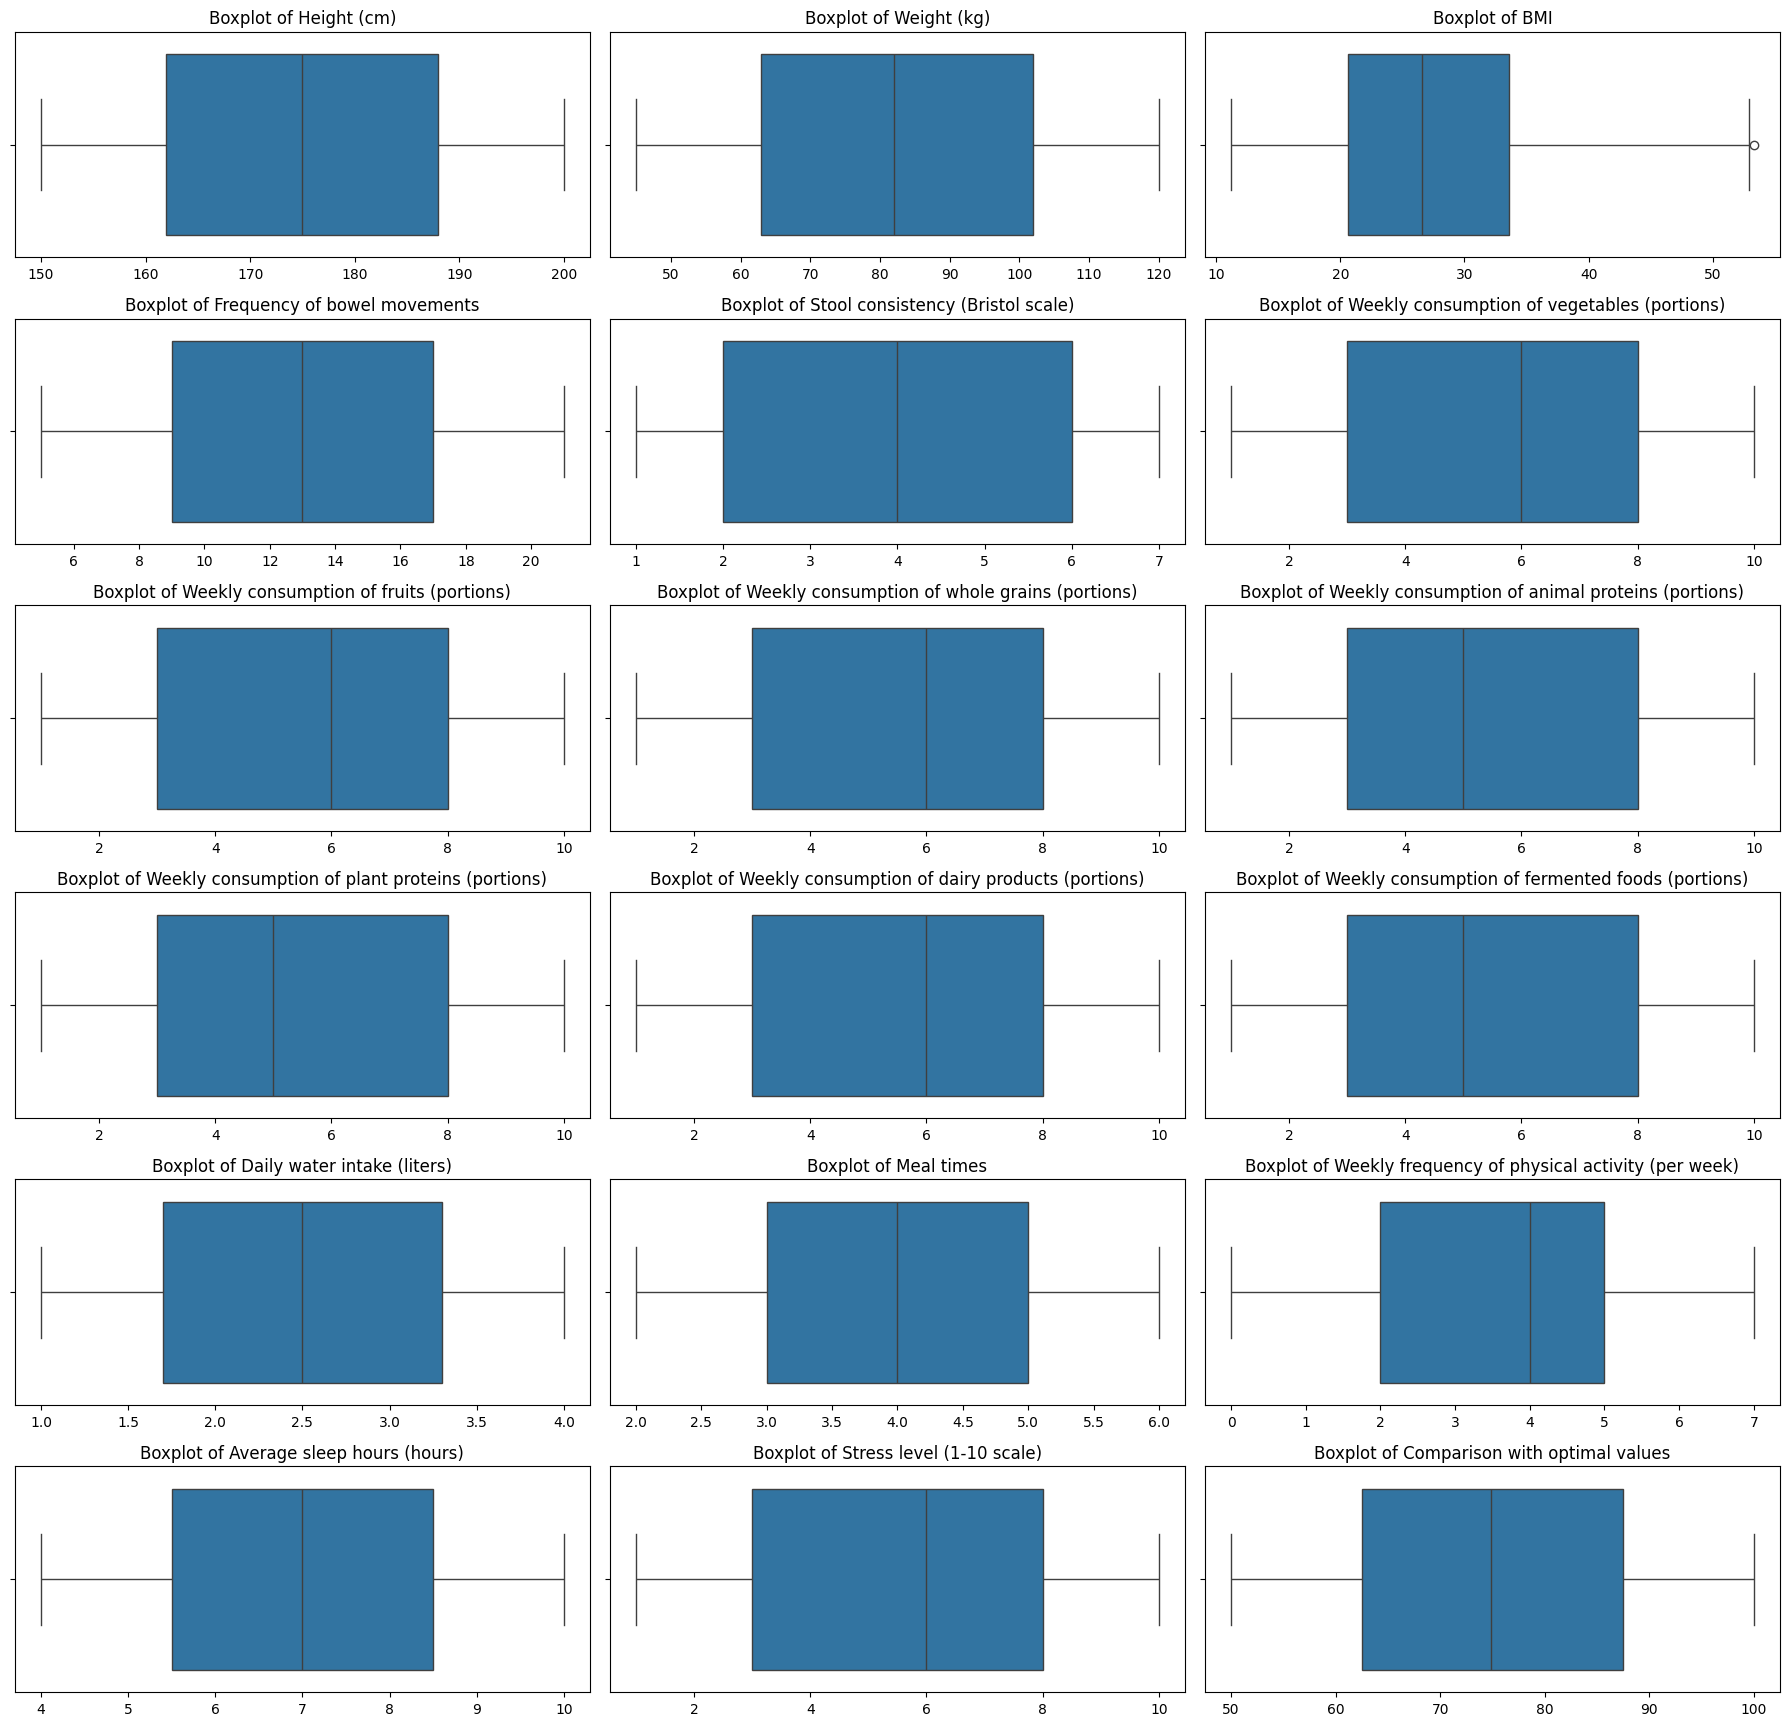

,0


In [61]:

missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)


numerical_features = df.select_dtypes(include=['int64', 'float64']).columns


import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=len(numerical_features) // 3 + 1, ncols=3, figsize=(18, 20))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel("")


for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

missing_values


Identify class imbalance

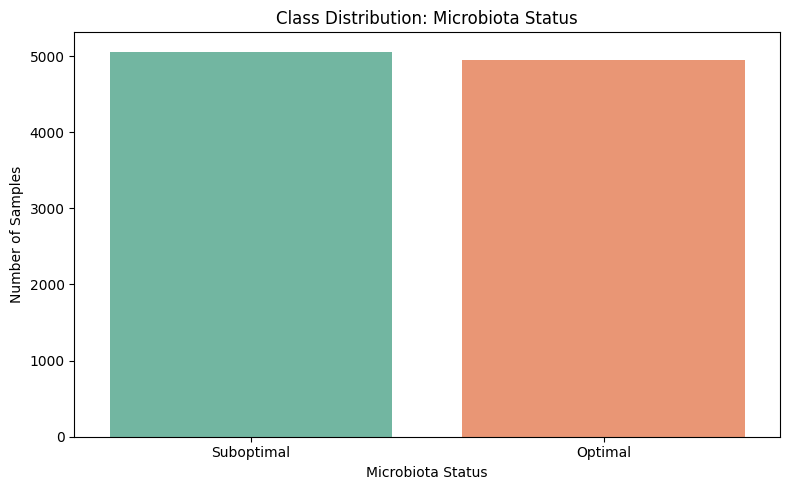

,count
Current status of microbiota,
Suboptimal,5058
Optimal,4942


In [62]:
class_counts = df['Current status of microbiota'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2")
plt.title("Class Distribution: Microbiota Status")
plt.xlabel("Microbiota Status")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

class_counts


This is a binary classification, not multiclass yet because In Dataset I couldn't find any class called At Risk:

class distribution :

Suboptimal: 50.58%
Optimal: 49.42%

✅ No missing values detected in the dataset — all features are complete.

This means we can skip imputation/removal and move directly to the next preprocessing step.

In [53]:
# Check for missing values again to confirm
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)


missing_summary


,0


Encode categorical variables (e.g., Label Encoding, One-Hot Encoding)

In [63]:
from sklearn.preprocessing import LabelEncoder


columns_to_drop = [
    'Residential Address',
    'Supplement Plan - Recommended products',
    'Supplement Plan - Dosages and timings',
    'Meal Plan - Recommended/avoided foods',
    'Weekly menu',
    'Personalized recipes'
]

df_reduced = df.drop(columns=columns_to_drop)


categorical_features = df_reduced.select_dtypes(include='object').columns
nominal_features = [col for col in categorical_features if col != 'Current status of microbiota']


df_encoded = pd.get_dummies(df_reduced, columns=nominal_features, drop_first=True)


label_encoder = LabelEncoder()
df_encoded['Microbiota_Status_Label'] = label_encoder.fit_transform(df['Current status of microbiota'])


df_encoded.drop(columns=['Current status of microbiota'], inplace=True)


print("Encoded dataset shape:", df_encoded.shape)
df_encoded.head()


Encoded dataset shape: (10000, 199)


,Height (cm),Weight (kg),BMI,Previous gastrointestinal issues,Frequency of bowel movements,Stool consistency (Bristol scale),Presence of bloating,Presence of gas,Presence of abdominal pain,Difficult digestion,...,"Relevant family history_Heart disease, Diabetes","Relevant family history_Heart disease, Hypertension","Relevant family history_Hypertension, Cancer","Relevant family history_Hypertension, Diabetes","Relevant family history_Hypertension, Heart disease",Other supplements_Multivitamins,Other supplements_Omega-3,Other supplements_Vitamin D,Intestinal health indicators_Suboptimal,Microbiota_Status_Label
0,173,120,40.1,True,6,2,False,True,False,True,...,False,False,False,False,False,False,False,False,False,0
1,183,110,32.8,False,18,6,True,True,True,True,...,False,False,True,False,False,True,False,False,True,1
2,160,111,43.4,False,6,6,False,True,False,True,...,False,False,False,False,True,False,True,False,False,1
3,177,75,23.9,True,16,7,True,False,True,False,...,False,False,False,False,False,False,True,False,False,0
4,170,97,33.6,True,17,4,True,False,False,True,...,False,False,False,False,False,False,True,False,False,0


In [8]:
from sklearn.preprocessing import StandardScaler

# Identify numerical features to scale (excluding the label)
numerical_columns = df_encoded.select_dtypes(include=['int64', 'float64']).columns
numerical_columns = [col for col in numerical_columns if col != 'Microbiota_Status_Label']

# Initialize scaler
scaler = StandardScaler()

# Apply standardization
df_encoded[numerical_columns] = scaler.fit_transform(df_encoded[numerical_columns])

# Display shape and first few rows
df_encoded[numerical_columns + ['Microbiota_Status_Label']].head()


,Height (cm),Weight (kg),BMI,Frequency of bowel movements,Stool consistency (Bristol scale),Weekly consumption of vegetables (portions),Weekly consumption of fruits (portions),Weekly consumption of whole grains (portions),Weekly consumption of animal proteins (portions),Weekly consumption of plant proteins (portions),Weekly consumption of dairy products (portions),Weekly consumption of fermented foods (portions),Daily water intake (liters),Meal times,Weekly frequency of physical activity (per week),Average sleep hours (hours),Stress level (1-10 scale),Comparison with optimal values,Microbiota_Status_Label
0,-0.126180,1.703746,1.413641,-1.420041,-1.015742,-1.578912,-1.209762,0.167708,-1.183528,-1.211541,-0.869057,-0.173437,1.378582,0.696159,-1.540825,-1.148490,0.172573,0.677198,0
1,0.547393,1.250452,0.591163,1.018321,0.976104,-0.538877,-0.862947,-1.203855,-0.838848,-0.165576,1.554801,1.568946,-0.229335,-0.713498,-1.540825,1.221807,0.172573,-0.297663,1
2,-1.001826,1.295781,1.785446,-1.420041,0.976104,0.154480,-0.516131,-0.175183,1.229232,1.577699,1.554801,-1.567343,-1.607550,-1.418327,1.088943,0.065565,0.875088,0.357583,1
3,0.143249,-0.336077,-0.411585,0.611927,1.474066,1.194515,1.564763,1.196380,-1.183528,1.229044,0.516005,-0.870390,-1.607550,1.400988,1.088943,-0.396932,0.523830,-0.778826,0
4,-0.328253,0.661170,0.681297,0.815124,-0.019819,1.194515,-0.862947,-0.860964,-1.528208,-0.862886,-0.522791,-0.870390,0.115219,-0.008669,1.527238,-1.264114,0.875088,0.141024,0


Derive composite metrics (e.g., Plant-to-Animal Protein Ratio)


In [9]:
# First, create the composite feature in the main DataFrame
df['Plant_to_Animal_Protein_Ratio'] = (
    df['Weekly consumption of plant proteins (portions)'] /
    (df['Weekly consumption of animal proteins (portions)'] + 1e-5)
)

# Then define the enriched feature list
enriched_features = [
    'Frequency of bowel movements',
    'Stool consistency (Bristol scale)',
    'Presence of bloating',
    'Presence of gas',
    'Presence of abdominal pain',
    'Difficult digestion',
    'Previous gastrointestinal issues',
    'Weekly consumption of fermented foods (portions)',
    'Weekly consumption of vegetables (portions)',
    'Weekly consumption of fruits (portions)',
    'Weekly consumption of whole grains (portions)',
    'Daily water intake (liters)',
    'Alcohol consumption',
    'Recent use of antibiotics',
    'Probiotics', 'Prebiotics', 'Vitamins', 'Minerals', 'Other supplements',
    'Plant_to_Animal_Protein_Ratio',
    'BMI', 'Average sleep hours (hours)', 'Stress level (1-10 scale)',
    'Weekly frequency of physical activity (per week)',
    'Current status of microbiota'  # Target variable
]

# Subset the DataFrame only after ensuring all features exist
df_enriched = df[enriched_features].dropna()


In [10]:
df_enriched

,Frequency of bowel movements,Stool consistency (Bristol scale),Presence of bloating,Presence of gas,Presence of abdominal pain,Difficult digestion,Previous gastrointestinal issues,Weekly consumption of fermented foods (portions),Weekly consumption of vegetables (portions),Weekly consumption of fruits (portions),...,Prebiotics,Vitamins,Minerals,Other supplements,Plant_to_Animal_Protein_Ratio,BMI,Average sleep hours (hours),Stress level (1-10 scale),Weekly frequency of physical activity (per week),Current status of microbiota
0,6,2,False,True,False,True,True,5,1,2,...,False,True,False,Magnesium,0.999995,40.1,5.0,6,0,Optimal
1,18,6,True,True,True,True,False,10,4,3,...,False,False,False,Multivitamins,1.666661,32.8,9.1,6,0,Suboptimal
2,6,6,False,True,False,True,False,1,6,4,...,True,False,True,Omega-3,1.111110,43.4,7.1,8,6,Suboptimal
3,16,7,True,False,True,False,True,3,9,10,...,True,False,True,Omega-3,4.499978,23.9,6.3,7,6,Optimal
4,17,4,True,False,False,True,True,3,9,3,...,False,True,True,Omega-3,2.999970,33.6,4.8,8,7,Optimal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15,6,True,True,True,True,True,9,3,8,...,True,True,True,Magnesium,2.999990,30.6,4.2,5,0,Suboptimal
9996,19,6,False,True,True,False,False,7,2,8,...,False,False,False,Vitamin D,4.999975,22.6,7.3,3,0,Suboptimal
9997,13,4,True,False,False,False,True,4,8,3,...,False,False,False,Multivitamins,1.124999,33.9,6.8,7,5,Optimal
9998,9,2,False,True,True,False,False,3,2,2,...,True,False,True,Omega-3,6.999930,44.9,4.7,2,7,Optimal


Convert ordinal data to bins (e.g., stress level)


In [11]:
# Copy dataset for feature engineering
df_fe_binned = df_enriched.copy()

# Convert "Stress level (1-10 scale)" into ordinal bins
# Define bins and labels
stress_bins = [0, 3, 6, 10]
stress_labels = ['Low', 'Moderate', 'High']

# Create binned column
df_fe_binned['Stress_Level_Binned'] = pd.cut(
    df_fe_binned['Stress level (1-10 scale)'],
    bins=stress_bins,
    labels=stress_labels,
    include_lowest=True
)

# Show distribution of binned stress levels
df_fe_binned['Stress_Level_Binned'].value_counts()


,count
Stress_Level_Binned,
High,4017
Moderate,3024
Low,2959


Highlight gut health-related features using domain knowledge


In [12]:
# Define key gut health-related features
gut_health_features = [
    'Frequency of bowel movements',
    'Stool consistency (Bristol scale)',
    'Presence of bloating',
    'Presence of gas',
    'Presence of abdominal pain',
    'Difficult digestion',
    'Previous gastrointestinal issues',
    'Weekly consumption of fermented foods (portions)',
    'Weekly consumption of vegetables (portions)',
    'Weekly consumption of fruits (portions)',
    'Weekly consumption of whole grains (portions)',
    'Plant_to_Animal_Protein_Ratio',
    'Daily water intake (liters)',
    'Alcohol consumption',
    'Recent use of antibiotics',
    'Probiotics',
    'Prebiotics',
    'Vitamins',
    'Minerals',
    'Other supplements',
    'Current status of microbiota'  # Target
]

# Extract relevant features
df_gut_health = df_fe_binned[gut_health_features].copy()

# Display basic information
print("Gut health feature set shape:", df_gut_health.shape)
print(df_gut_health.head())


Gut health feature set shape: (10000, 21)
   Frequency of bowel movements  Stool consistency (Bristol scale)  \
0                             6                                  2   
1                            18                                  6   
2                             6                                  6   
3                            16                                  7   
4                            17                                  4   

   Presence of bloating  Presence of gas  Presence of abdominal pain  \
0                 False             True                       False   
1                  True             True                        True   
2                 False             True                       False   
3                  True            False                        True   
4                  True            False                       False   

   Difficult digestion  Previous gastrointestinal issues  \
0                 True                      

Step 4: Model Creation

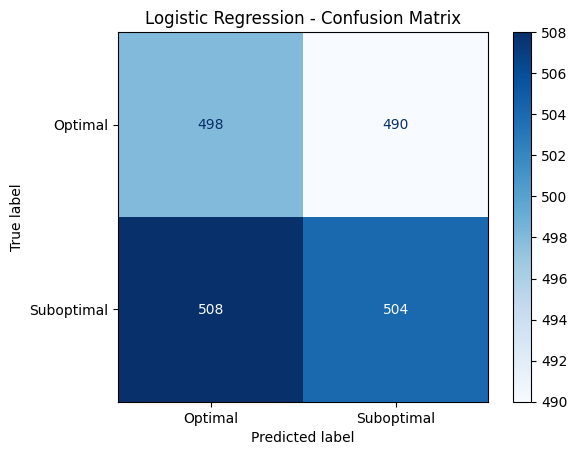

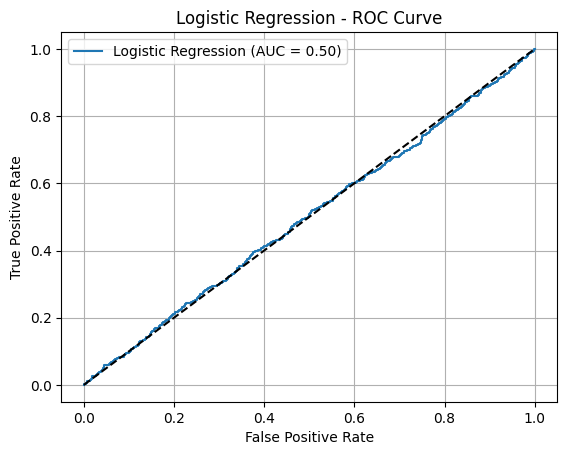

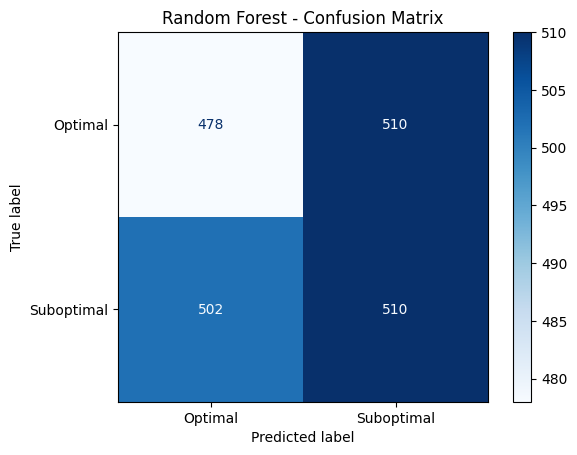

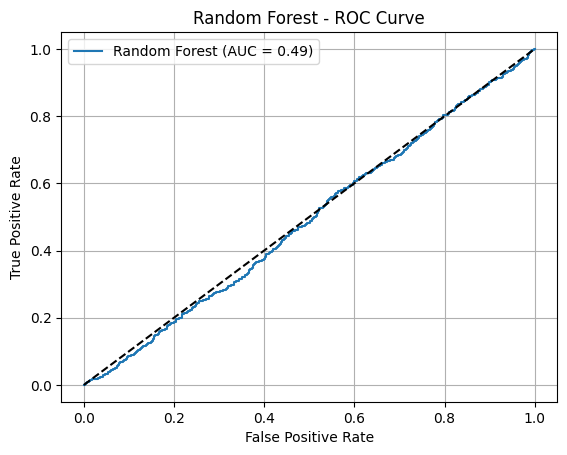

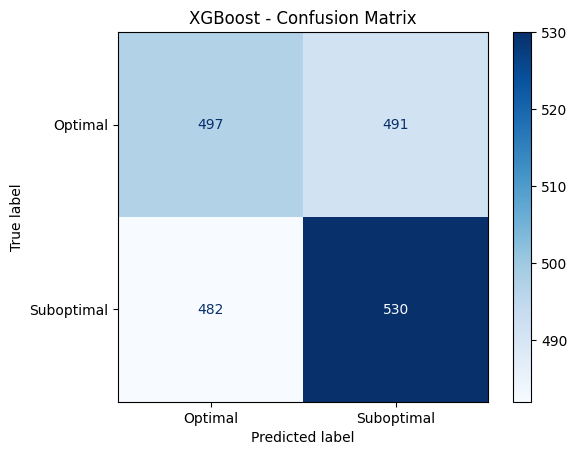

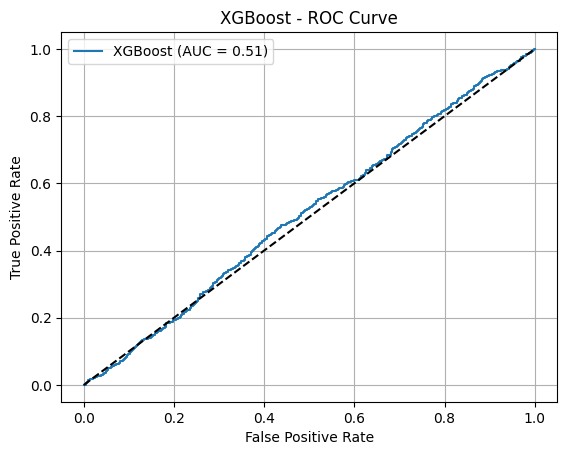

[LightGBM] [Info] Number of positive: 4046, number of negative: 3954
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505750 -> initscore=0.023001
[LightGBM] [Info] Start training from score 0.023001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


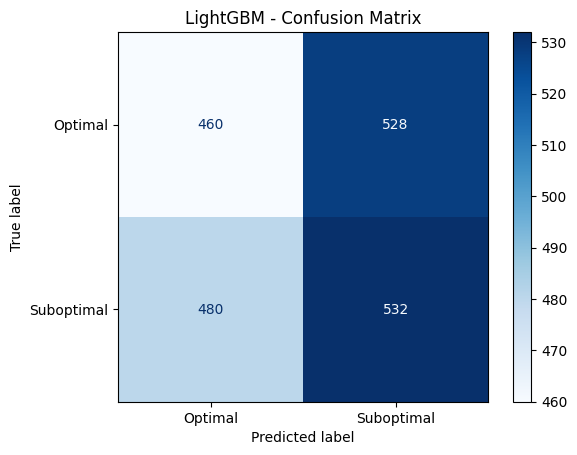

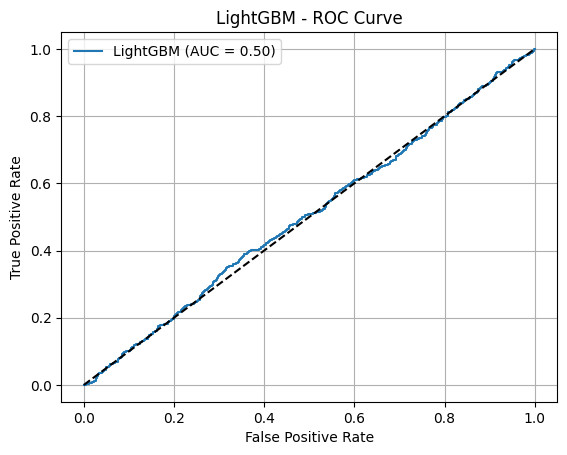

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


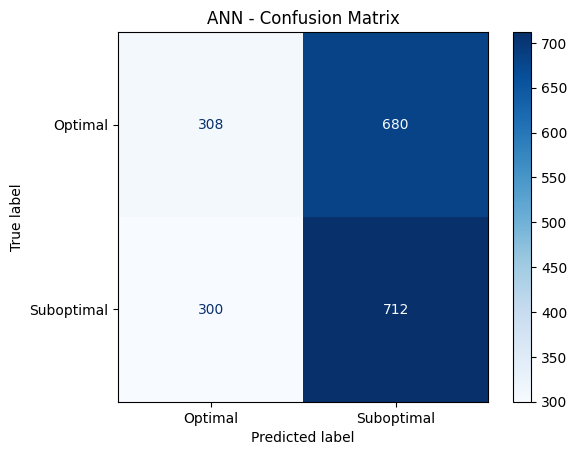

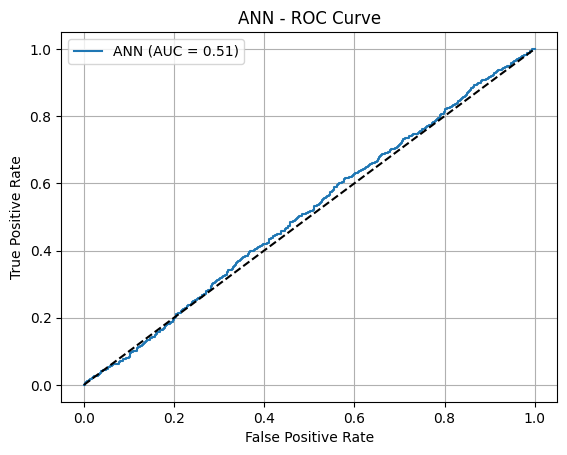

,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC
Logistic Regression,0.518250,0.5010,0.507042,0.498024,0.502493,0.499284
Random Forest,0.828000,0.4940,0.500000,0.503953,0.501969,0.489882
XGBoost,0.942875,0.5135,0.519099,0.523715,0.521397,0.511077
LightGBM,0.829125,0.4960,0.501887,0.525692,0.513514,0.503452
ANN,0.532375,0.5100,0.511494,0.703557,0.592346,0.511242


In [18]:


df.columns = df.columns.str.strip().str.lower()

# Define columns for gut symptoms
symptom_cols = ['presence of bloating', 'presence of gas', 'presence of abdominal pain', 'difficult digestion']
plant_protein_col = 'weekly consumption of plant proteins (portions)'.lower()
animal_protein_col = 'weekly consumption of animal proteins (portions)'.lower()
fiber_cols = ['weekly consumption of vegetables (portions)'.lower(),
              'weekly consumption of fruits (portions)'.lower(),
              'weekly consumption of whole grains (portions)'.lower()]

# Helper to get column or zeros if missing
def get_col_safe(df, col):
    return df[col] if col in df.columns else pd.Series(np.zeros(len(df)), index=df.index)

df['gut_symptom_score'] = sum(get_col_safe(df, c).astype(int) for c in symptom_cols)
df['plant_to_animal_protein_ratio'] = get_col_safe(df, plant_protein_col) / (get_col_safe(df, animal_protein_col) + 1e-5)
df['fiber_score'] = sum(get_col_safe(df, c) for c in fiber_cols)

# Binary target: Optimal vs Not Optimal
if 'at risk' in df['current status of microbiota'].str.lower().unique():
    df['microbiota_binary'] = df['current status of microbiota'].apply(lambda x: 'optimal' if x.lower() == 'optimal' else 'not optimal')
else:
    df['microbiota_binary'] = df['current status of microbiota']

# Features to use
features = [
    'bmi',
    'average sleep hours (hours)'.lower(),
    'stress level (1-10 scale)'.lower(),
    'daily water intake (liters)'.lower(),
    'alcohol consumption',
    'weekly frequency of physical activity (per week)'.lower(),
    'gut_symptom_score',
    'plant_to_animal_protein_ratio',
    'fiber_score',
    'probiotics',
    'prebiotics',
    'vitamins',
    'minerals'
]

df_model = df[features + ['microbiota_binary']].dropna()
label_enc = LabelEncoder()
df_model['target'] = label_enc.fit_transform(df_model['microbiota_binary'])

X = df_model.drop(columns=['microbiota_binary', 'target'])
y = df_model['target']

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# === Define models ===
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=8, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, max_depth=8, random_state=42)
}

results = {}

# Train baseline and boosting models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]

    precision = precision_score(y_test, y_test_pred, average='binary')
    recall = recall_score(y_test, y_test_pred, average='binary')
    f1 = f1_score(y_test, y_test_pred, average='binary')
    roc_auc = roc_auc_score(y_test, y_test_proba)

    results[name] = {
        'Train Accuracy': accuracy_score(y_train, y_train_pred),
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=label_enc.classes_, cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{name} - ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

# === ANN Model ===
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
input_dim = X_train.shape[1]

ann = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(y_train_cat.shape[1], activation='softmax')
])

ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = ann.fit(X_train, y_train_cat,
                  validation_split=0.2,
                  epochs=100,
                  batch_size=32,
                  callbacks=[early_stop],
                  verbose=0)

train_loss, train_acc = ann.evaluate(X_train, y_train_cat, verbose=0)
test_loss, test_acc = ann.evaluate(X_test, y_test_cat, verbose=0)
y_test_proba_ann = ann.predict(X_test)
y_test_pred_ann = np.argmax(y_test_proba_ann, axis=1)

precision_ann = precision_score(y_test, y_test_pred_ann, average='binary')
recall_ann = recall_score(y_test, y_test_pred_ann, average='binary')
f1_ann = f1_score(y_test, y_test_pred_ann, average='binary')
roc_auc_ann = roc_auc_score(y_test, y_test_proba_ann[:, 1])

results['ANN'] = {
    'Train Accuracy': train_acc,
    'Test Accuracy': test_acc,
    'Precision': precision_ann,
    'Recall': recall_ann,
    'F1 Score': f1_ann,
    'ROC AUC': roc_auc_ann
}

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_ann, display_labels=label_enc.classes_, cmap='Blues')
plt.title('ANN - Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_test_proba_ann[:,1])
plt.plot(fpr, tpr, label=f'ANN (AUC = {roc_auc_ann:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ANN - ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# === Final results ===
pd.DataFrame(results).T


In [19]:
!pip install pytorch-tabular pytorch-lightning torch --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 954.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [45]:


df.columns = df.columns.str.strip().str.lower()

symptom_cols = ['presence of bloating', 'presence of gas', 'presence of abdominal pain', 'difficult digestion']
plant_protein_col = 'weekly consumption of plant proteins (portions)'.lower()
animal_protein_col = 'weekly consumption of animal proteins (portions)'.lower()
fiber_cols = ['weekly consumption of vegetables (portions)'.lower(),
              'weekly consumption of fruits (portions)'.lower(),
              'weekly consumption of whole grains (portions)'.lower()]

def get_col_safe(df, col):
    return df[col] if col in df.columns else pd.Series(np.zeros(len(df)), index=df.index)

df['gut_symptom_score'] = sum(get_col_safe(df, c).astype(int) for c in symptom_cols)
df['plant_to_animal_protein_ratio'] = get_col_safe(df, plant_protein_col) / (get_col_safe(df, animal_protein_col) + 1e-5)
df['fiber_score'] = sum(get_col_safe(df, c) for c in fiber_cols)

# Binary target creation
if 'at risk' in df['current status of microbiota'].str.lower().unique():
    df['microbiota_binary'] = df['current status of microbiota'].apply(lambda x: 'optimal' if x.lower() == 'optimal' else 'not optimal')
else:
    df['microbiota_binary'] = df['current status of microbiota']

# Features
categorical_cols = ['alcohol consumption', 'probiotics', 'prebiotics', 'vitamins', 'minerals']
numerical_cols = [
    'bmi',
    'average sleep hours (hours)',
    'stress level (1-10 scale)',
    'daily water intake (liters)',
    'weekly frequency of physical activity (per week)',
    'gut_symptom_score',
    'plant_to_animal_protein_ratio',
    'fiber_score'
]

all_features = numerical_cols + categorical_cols

# Drop missing values
df_model = df[all_features + ['microbiota_binary']].dropna()

# Encode target
label_enc = LabelEncoder()
df_model['target'] = label_enc.fit_transform(df_model['microbiota_binary'])

# Train/test split
train_df, test_df = train_test_split(df_model, test_size=0.2, stratify=df_model['target'], random_state=42)

# --- Configurations for TabTransformer ---

data_config = DataConfig(
    target=['target'],
    continuous_cols=numerical_cols,
    categorical_cols=categorical_cols,
)

model_config = TabTransformerConfig(
    task="classification",
    loss="CrossEntropyLoss",
    metrics=["accuracy", "f1_score"],
    learning_rate=1e-3
)

trainer_config = TrainerConfig(
    max_epochs=50,
    accelerator='auto',
    devices=1,
    early_stopping_patience=10,
    load_best=False,
)

optimizer_config = OptimizerConfig()

# --- Initialize and train TabTransformer ---

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)


if not hasattr(tabular_model, 'model'):
    tabular_model.fit(train=train_df, validation=test_df)
else:
    print("Model already trained. Skipping fit.")


# --- Predictions and Evaluation ---

y_pred_proba = tabular_model.predict(test_df)


probability_cols = [col for col in y_pred_proba.columns if col.endswith('_probability')]


y_pred = y_pred_proba[probability_cols].idxmax(axis=1).apply(lambda x: int(x.split('_')[1])).values



if hasattr(label_enc, 'classes_'):
    target_names = label_enc.classes_
else:

    unique_targets = np.unique(df_model['target'])
    target_names = [f"Class_{i}" for i in unique_targets]
    print("Warning: label_enc.classes_ not found. Using generic target names.")

print(classification_report(test_df['target'], y_pred, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(test_df['target'], y_pred))

INFO:pytorch_tabular.tabular_model:Experiment Tracking is turned off
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_tabular.tabular_model:Preparing the DataLoaders
INFO:pytorch_tabular.tabular_datamodule:Setting up the datamodule for classification task
INFO:pytorch_tabular.tabular_model:Preparing the Model: TabTransformerModel
INFO:pytorch_tabular.tabular_model:Preparing the Trainer
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  271 K │ train │
│ 1 │ _embedding_layer │ Embedding2dLayer       │    520 │ train │
│ 2 │ _head            │ LinearHead             │    338 │ train │
│ 3 │ loss             │ CrossEntropyLoss       │      0 │ train │
└───┴──────────────────┴────────────────────────┴────────┴───────┘

Trainable params: 272 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 272 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 129                                                                                         
Modules in eval mode: 0

Output()

INFO:pytorch_tabular.tabular_model:Training the model completed


              precision    recall  f1-score   support

     Optimal       0.49      0.54      0.51       988
  Suboptimal       0.50      0.45      0.48      1012

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.50      0.49      0.49      2000

Confusion Matrix:
 [[530 458]
 [553 459]]


LSTM

In [50]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


X_data = df_model.drop(columns=['target', 'microbiota_binary'])
y_data = df_model['target'].values


numerical_ix = X_data.columns.get_indexer(numerical_cols)
categorical_ix = X_data.columns.get_indexer(categorical_cols)



preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)


X_processed = preprocessor.fit_transform(X_data)


if isinstance(X_processed, np.ndarray) and X_processed.dtype != np.float32:

     X_processed = X_processed.astype(np.float32)
elif hasattr(X_processed, 'toarray'):
    X_processed = X_processed.toarray().astype(np.float32)


X = X_processed
y = y_data

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


X_train_tensor = torch.tensor(X_train).unsqueeze(2)
X_test_tensor = torch.tensor(X_test).unsqueeze(2)

y_train_tensor = torch.tensor(y_train).long()
y_test_tensor = torch.tensor(y_test).long()

# Create Datasets and Loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# --- Define LSTM model ---

class LSTMClassifier(nn.Module):

    def __init__(self, input_size=1, hidden_size=64, num_layers=1, num_classes=2):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):

        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

# Instantiate model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMClassifier(input_size=1, hidden_size=64, num_layers=1, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- Training loop ---

epochs = 30
model.train()

for epoch in range(epochs):
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# --- Evaluation ---

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())



# Check if label_enc.classes_ exists and use it, otherwise use integer labels
if 'label_enc' in locals() and hasattr(label_enc, 'classes_'):
     report_target_names = label_enc.classes_
else:
     report_target_names = sorted(np.unique(all_labels)) # Use sorted integer labels


print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=report_target_names))
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

Epoch 1/30, Loss: 0.6940
Epoch 2/30, Loss: 0.6935
Epoch 3/30, Loss: 0.6933
Epoch 4/30, Loss: 0.6933
Epoch 5/30, Loss: 0.6933
Epoch 6/30, Loss: 0.6934
Epoch 7/30, Loss: 0.6932
Epoch 8/30, Loss: 0.6933
Epoch 9/30, Loss: 0.6932
Epoch 10/30, Loss: 0.6932
Epoch 11/30, Loss: 0.6932
Epoch 12/30, Loss: 0.6933
Epoch 13/30, Loss: 0.6932
Epoch 14/30, Loss: 0.6932
Epoch 15/30, Loss: 0.6933
Epoch 16/30, Loss: 0.6933
Epoch 17/30, Loss: 0.6932
Epoch 18/30, Loss: 0.6930
Epoch 19/30, Loss: 0.6933
Epoch 20/30, Loss: 0.6933
Epoch 21/30, Loss: 0.6932
Epoch 22/30, Loss: 0.6931
Epoch 23/30, Loss: 0.6931
Epoch 24/30, Loss: 0.6932
Epoch 25/30, Loss: 0.6932
Epoch 26/30, Loss: 0.6932
Epoch 27/30, Loss: 0.6932
Epoch 28/30, Loss: 0.6931
Epoch 29/30, Loss: 0.6932
Epoch 30/30, Loss: 0.6932
Classification Report:
               precision    recall  f1-score   support

     Optimal       0.45      0.05      0.10       988
  Suboptimal       0.50      0.94      0.65      1012

    accuracy                           0.

#Grid Search with GridSearchCV (Example: Random Forest)

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=3,
                           scoring='roc_auc',
                           # Change n_jobs from -1 to a positive integer, like 1 or 2
                           # Using 1 runs sequentially and avoids multiprocessing issues
                           n_jobs=1,
                           verbose=2)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best ROC AUC:", grid_search.best_score_)

best_rf = grid_search.best_estimator_

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END class_weight=balanced, max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END class_weight=balanced, max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END class_weight=balanced, max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END class_weight=balanced, max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.8s
[CV] END class_weight=balanced, max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.4s
[CV] END class_weight=balanced, max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END class_weight=balanced, max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.5s
[CV] END class_weight=balanced, max_depth=6, min_samples_leaf=1, min_samples

#Bayesian Optimization with Optuna (Example: XGBoost)

In [67]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 12.6 MB/s eta 0:00:00


In [68]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }

    model = XGBClassifier(**param, random_state=42)
    score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=3).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print('Best trial:', study.best_trial.params)

best_xgb = XGBClassifier(**study.best_trial.params, random_state=42)
best_xgb.fit(X_train, y_train)


[I 2025-05-16 16:15:16,441] A new study created in memory with name: no-name-063c4249-55bd-4a08-8536-4692deb3c955
[I 2025-05-16 16:15:16,855] Trial 0 finished with value: 0.5055697687410652 and parameters: {'max_depth': 4, 'learning_rate': 0.00032898063714091114, 'n_estimators': 132, 'subsample': 0.5031485300810439, 'colsample_bytree': 0.541742149022505, 'reg_alpha': 0.30963208023908273, 'reg_lambda': 0.3853774035095606}. Best is trial 0 with value: 0.5055697687410652.
[I 2025-05-16 16:15:17,499] Trial 1 finished with value: 0.5080323113618599 and parameters: {'max_depth': 5, 'learning_rate': 0.002567218495164668, 'n_estimators': 172, 'subsample': 0.9602048169708415, 'colsample_bytree': 0.8718106005151169, 'reg_alpha': 0.6059960438810442, 'reg_lambda': 0.771116328012888}. Best is trial 1 with value: 0.5080323113618599.
[I 2025-05-16 16:15:18,101] Trial 2 finished with value: 0.49719586410860456 and parameters: {'max_depth': 4, 'learning_rate': 0.17025915482858284, 'n_estimators': 213, 

Best trial: {'max_depth': 9, 'learning_rate': 0.0010430726014819386, 'n_estimators': 95, 'subsample': 0.7793622240586106, 'colsample_bytree': 0.5041803263454375, 'reg_alpha': 0.41852214965268747, 'reg_lambda': 0.7435006232850199}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5041803263454375, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0010430726014819386,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=95, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Full Optuna hyperparameter tuning example for XGBoost:

In [69]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),   # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0), # L2 regularization
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    model = XGBClassifier(**params, random_state=42)

    # Use 3-fold CV and AUC as scoring
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()
    return score

# Create study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_trial.params)

# Train best model on full train set
best_params = study.best_trial.params
best_model = XGBClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Evaluate on test set
from sklearn.metrics import accuracy_score, roc_auc_score

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Test ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")


[I 2025-05-16 16:18:04,827] A new study created in memory with name: no-name-ecf6991f-0c19-4cb2-9e71-9f62eebdf82c
[I 2025-05-16 16:18:05,440] Trial 0 finished with value: 0.5036660190320502 and parameters: {'learning_rate': 0.12260913179638665, 'max_depth': 6, 'n_estimators': 142, 'subsample': 0.599698338522604, 'colsample_bytree': 0.9074620384222045, 'reg_alpha': 0.074381025890628, 'reg_lambda': 0.775323005953494, 'min_child_weight': 8}. Best is trial 0 with value: 0.5036660190320502.
[I 2025-05-16 16:18:10,165] Trial 1 finished with value: 0.5099432871973758 and parameters: {'learning_rate': 0.027795137533985916, 'max_depth': 13, 'n_estimators': 156, 'subsample': 0.6789792505871355, 'colsample_bytree': 0.573082681529619, 'reg_alpha': 0.916619325138115, 'reg_lambda': 0.8710334712020715, 'min_child_weight': 2}. Best is trial 1 with value: 0.5099432871973758.
[I 2025-05-16 16:18:11,243] Trial 2 finished with value: 0.49995282378453837 and parameters: {'learning_rate': 0.0002008440768191

Best hyperparameters: {'learning_rate': 0.015981456935469325, 'max_depth': 11, 'n_estimators': 184, 'subsample': 0.9745562851609139, 'colsample_bytree': 0.623566339270182, 'reg_alpha': 0.7293446730258583, 'reg_lambda': 0.1486348504409073, 'min_child_weight': 1}
Test Accuracy: 0.4965
Test ROC AUC: 0.4932


In [77]:
!pip install --upgrade notebook nbconvert nbformat


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstalling jupyter-client-6.1.12:
      Successfully uninstalled jupyter-client-6.1.12
  Attempting uninstall: jupyter-server
    Found existing installation: jupyter-server 1.16.0
    Uninstalling jupyter-server-1.16.0:
      Successfully uninstalled jupyter-server-1.16.0
  Attempting uninstall: notebook
    Found existing installation: noteboo